In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
from os import listdir
from os.path import exists
import time

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import manifold, decomposition

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import *

In [3]:
import cv2

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
# Utilisation d'autre chose que VGG16 car trop lent et surdimensionné pour nous
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.applications.densenet import DenseNet121 as MobileNetV2
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing.image import load_img

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from plot_keras_history import show_history, plot_history

# Récupération des données

In [7]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [8]:
data = pd.read_csv(path_csv)

## Mise en forme et quelques stats

### Gestion de l'arbre de catégories

In [9]:
# Récupère le noeud à la profondeur "level"
# (ou la feuille si level va trop profond)
# (ou la racine si level remonte trop)
def get_from_tree(tree, level):
    if len(tree) > level and len(tree) >= -level:
        return tree[level]
    elif len(tree) < -level:
        return tree[0]
    else:
        return tree[-1]

In [10]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [11]:
print("Nombre total de catégories possible (en comptant noeuds et feuilles) :")
print(len(data['product_category_list'].explode().unique()))

Nombre total de catégories possible (en comptant noeuds et feuilles) :
1126


In [12]:
print("Nombre total de catégories (feuilles) :")
print(len(data['product_category_tree'].unique()))

Nombre total de catégories (feuilles) :
642


In [13]:
tmp = data['product_category_list'].str.len()
print("Taille minimum d'une branche :", tmp.min())
print("Taille maximum d'une branche :", tmp.max())

Taille minimum d'une branche : 2
Taille maximum d'une branche : 7


Observation des catégories récupérées selon le niveau choisi :

In [14]:
level = 1

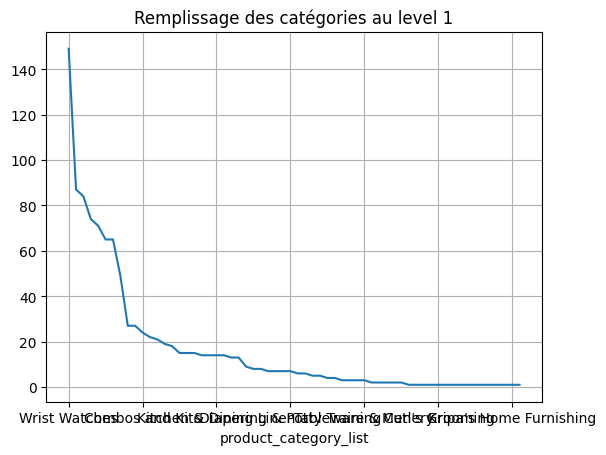

In [15]:
tmp = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))
ax = tmp.value_counts().plot(grid=True, title="Remplissage des catégories au level "+str(level))

In [16]:
level = -1

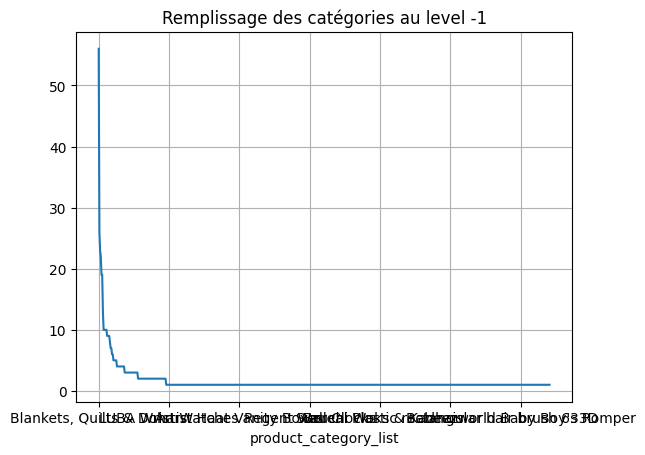

In [17]:
tmp = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))
ax = tmp.value_counts().plot(grid=True, title="Remplissage des catégories au level "+str(level))

Visualisation de l'arbre

In [18]:
import graphviz

In [19]:
dot = graphviz.Digraph()

lien_deja = set()

# Ajouter la racine de l'arbre
dot.node('Racine')

for n in data['product_category_list'].explode().unique():
    dot.node(n)

def ajouter_lien(precedent, actuel, suite):
    nom = "{}/{}".format(precedent, actuel)
    if nom not in lien_deja:
        dot.edge(precedent, actuel)
        lien_deja.add(nom)
    
    if len(suite) > 0 :
        ajouter_lien(actuel, suite[0], suite[1:])

for l in data['product_category_list']:
    ajouter_lien('Racine', l[0], l[1:])

# Affichage l'arbre
# dot.render('categories', view=True)

#### Choix du niveau de catégorie classique

In [20]:
level = 0

In [21]:
data['cat_group'] = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))

#### Version personalisée des catégories

In [22]:
# Nombre minimum d'éléments pour faire une catégorie
nb_min_elements = 30

In [23]:
index = -1

In [24]:
# Initialisation des données
tmp = data[['product_category_list']].copy()
tmp.columns = ['list']
tmp['actual'] = tmp['list'].apply(lambda tree : get_from_tree(tree, index))
tmp

,list,actual
0,"[Home Furnishing, Curtains & Accessories, Curt...",Elegance Polyester Multicolor Abstract Eyelet ...
1,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...","Sathiyas Cotton Bath Towel (3 Bath Towel, Red,..."
2,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Eurospa Cotton Terry Face Towel Set (20 PIECE ...
3,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",SANTOSH ROYAL FASHION Cotton Printed King size...
4,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Jaipur Print Cotton Floral King sized Double B...
...,...,...
1045,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Oren Empower Stickers
1046,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Stickers
1047,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Uberlyfe Stickers
1048,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Stickers


Application de l'algo : On part des feuilles de l'arbre, et tant qu'il n'y a pas assez l'éléments dans la catégorie on les remonte d'un niveau

In [25]:
old_unique = 0

In [26]:
while old_unique != len(tmp['actual'].unique()):
    old_unique = len(tmp['actual'].unique())
    index -= 1
    tmp_actual = tmp.groupby('actual').count()
    tmp_actual = tmp_actual.loc[tmp_actual['list']<nb_min_elements]
    
    mask = tmp['actual'].isin(tmp_actual.index)
    
    tmp.loc[mask, 'actual'] = tmp.loc[mask, 'list'].apply(lambda tree : get_from_tree(tree, index))

In [27]:
# Modification pour éviter une catégorie qui se retrouve seule sinon
tmp.loc[tmp['actual']=="Wrist Watches", 'actual'] = "Watches"

In [28]:
tmp['actual'].value_counts()

actual
Watches                       150
Baby Care                     110
Home Furnishing                93
Beauty and Personal Care       86
Kitchen & Dining               76
Coffee Mugs                    74
Combos                         64
Computers                      63
Showpieces                     60
Blankets, Quilts & Dohars      57
Home Decor & Festive Needs     56
Routers                        49
Baby Girls' Clothes            40
USB Gadgets                    38
Ethnic                         34
Name: count, dtype: int64

In [29]:
#data['cat_group'] = tmp['actual']

### Finalisation mise en forme

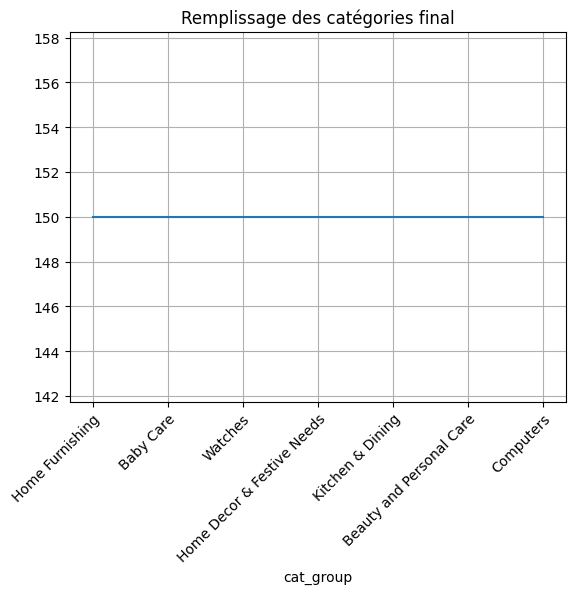

In [30]:
df = data['cat_group'].value_counts()
ax = df.plot.line(grid=True, title="Remplissage des catégories final")

ax.set_xticks(range(len(df.index)), list(df.index), rotation=45, ha='right', rotation_mode='anchor')
pass

In [31]:
# Nombre minimum d'éléments pour garder cette catégorie
nb_min_elements = 3

Mise en forme

In [32]:
data_final = data[['image', 'product_category_list', 'cat_group']].copy()
data_final.columns = ['img', 'cat_lst', 'cat']
data_final['img'] = path_img+'/'+data_final['img']

Conversion des labels

In [33]:
list_labels = list(data_final['cat'].value_counts().index)
data_final['label'] = data_final['cat'].apply(lambda e : list_labels.index(e))

Récupération d'infos et suppression des lignes avec des catégories trop vides

In [34]:
nb_cat_little = (data_final['cat'].value_counts() > nb_min_elements).sum()
nb_cat = len(list_labels)

In [35]:
print("Nombre de catégories total :", nb_cat)
print("Nombre de catégories de plus de", nb_min_elements, "élément :", nb_cat_little)

Nombre de catégories total : 7
Nombre de catégories de plus de 3 élément : 7


In [36]:
data_little = data_final.loc[data_final['cat'].isin(list_labels[:nb_cat_little])].copy().reset_index(drop=True)

In [37]:
data_little

,img,cat_lst,cat,label
0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,"[Home Furnishing, Curtains & Accessories, Curt...",Home Furnishing,0
1,./data/Flipkart/Images/7b72c92c2f6c40268628ec5...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,1
2,./data/Flipkart/Images/64d5d4a258243731dc7bbb1...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,1
3,./data/Flipkart/Images/d4684dcdc759dd9cdf41504...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Home Furnishing,0
4,./data/Flipkart/Images/6325b6870c54cd47be6ebfb...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Home Furnishing,0
...,...,...,...,...
1045,./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Baby Care,1
1046,./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,1
1047,./data/Flipkart/Images/5912e037d12774bb73a2048...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Baby Care,1
1048,./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,1


Export du dataset

In [38]:
data_little.to_csv("./data/data_little.csv", index=False)

# Classification via MobileNetV2

In [39]:
# Représentation des vecteurs et catégories en 2D
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat_little), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

In [40]:
def cat_to_label(l):
    return np.argmax(l)

## Initialisation du modèle

In [44]:
#from tensorflow.keras.applications.efficientnet import EfficientNetB0 as MobileNetV2
#from tensorflow.keras.applications.efficientnet import preprocess_input

In [45]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [46]:
input_shape = MobileNetV2().input_shape
input_shape

(None, 224, 224, 3)

Chargement du modèle en figeant toutes les couches sauf les dernières (celles de classification)

In [47]:
base_model = MobileNetV2(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [48]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

Ajout des dernières couches pour la prédiction addapté à nos targets

In [49]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 70)                4390470   
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1988      
                                                                 
 dense_2 (Dense)             (None, 7)                 203       
                                                        

## Chargment des images

In [51]:
# Conversion des images aux bonnes dimensions et format 
def preprocess_image(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    image = preprocess_input(image)
    return image

Chargement et conversion de toutes les images du dataset

In [52]:
data_X = list(data_little["img"].apply(preprocess_image))
data_X = np.asarray(data_X).astype(np.float32)

Conversion des targets

In [53]:
data_y = to_categorical(data_little['label'], num_classes=nb_cat_little)

Création des sets d'entrainement et de test

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, stratify=data_y)

## Classification

In [55]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.005, mode='max', patience=6, restore_best_weights=True)
#es = EarlyStopping(monitor='val_loss', min_delta = 0.002, mode='min', patience=6, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/30
16/16 [==============================] - 18s 1s/step - loss: 4.2796 - accuracy: 0.4248 - val_loss: 1.3035 - val_accuracy: 0.6825
Epoch 2/30
16/16 [==============================] - 16s 1s/step - loss: 1.5824 - accuracy: 0.6992 - val_loss: 1.5061 - val_accuracy: 0.7156
Epoch 3/30
16/16 [==============================] - 16s 1s/step - loss: 0.8963 - accuracy: 0.8211 - val_loss: 1.0939 - val_accuracy: 0.7346
Epoch 4/30
16/16 [==============================] - 15s 975ms/step - loss: 0.5612 - accuracy: 0.8557 - val_loss: 1.4361 - val_accuracy: 0.7915
Epoch 5/30
16/16 [==============================] - 15s 973ms/step - loss: 0.4287 - accuracy: 0.8923 - val_loss: 1.3686 - val_accuracy: 0.7488
Epoch 6/30
16/16 [==============================] - 15s 973ms/step - loss: 0.3629 - accuracy: 0.9085 - val_loss: 1.2780 - val_accuracy: 0.7488
Epoch 7/30
16/16 [==============================] - 16s 996ms/step - loss: 0.2198 - accuracy: 0.9411 - val_loss: 1.3634 - val_accuracy: 0.7441
Epoch 8/

## Résultats

In [56]:
def evaluate_model(model, X, y):
    start = time.time()
    y_pred = model.predict(X)
    enlapsed = time.time() - start

    print()
    print("Temps de prédiction (en s): ", round(enlapsed, 2))
    print("Nombre de valeurs à prédire : ", len(X))
    print("Temps moyen par prédiction (en ms): ", int(1000 * enlapsed/len(X)))
    
    y_label = [cat_to_label(e) for e in y]
    y_pred_label = [cat_to_label(e) for e in y_pred]
    
    print()
    print("Accuracy score (taux de classes correctements prédites) sur le set de test :")
    print(accuracy_score(y_label, y_pred_label))
    
    #print()
    #print("Accuracy score (taux de classes présentes dans le top 2) sur le set de test :")
    #print(top_k_accuracy_score(y_label, y_pred, k=2))

    print()
    print("Score de Cohen kappa sur le set de test :")
    print(cohen_kappa_score(y_label, y_pred_label))

    print()
    print("Coefficient de corrélation de Matthews sur le set de test :")
    print(matthews_corrcoef(y_label, y_pred_label))
    
    return y_label, y_pred_label, y_pred

In [57]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 9s 703ms/step

Temps de prédiction (en s):  8.65
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  24

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.7896253602305475

Score de Cohen kappa sur le set de test :
0.7545255446158616

Coefficient de corrélation de Matthews sur le set de test :
0.7568618452630426


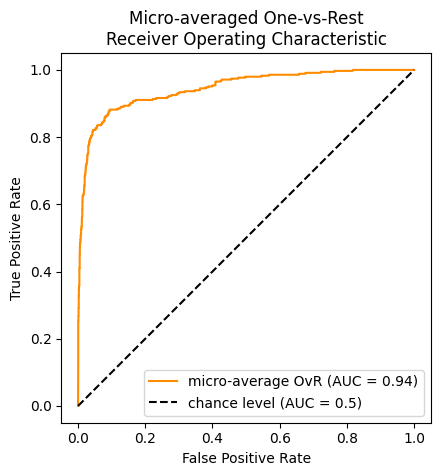

In [58]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Résultats au cas pas cas

In [59]:
labels_little = data_little.sort_values('label')['cat'].unique()

In [60]:
print(classification_report(
    y_test_label,
    pred_test_label,
    target_names=labels_little,
    zero_division=0))

                            precision    recall  f1-score   support

           Home Furnishing       0.75      0.73      0.74        49
                 Baby Care       0.78      0.72      0.75        50
                   Watches       0.96      0.94      0.95        49
Home Decor & Festive Needs       0.76      0.84      0.80        50
          Kitchen & Dining       0.79      0.68      0.73        50
  Beauty and Personal Care       0.95      0.71      0.81        49
                 Computers       0.64      0.90      0.75        50

                  accuracy                           0.79       347
                 macro avg       0.80      0.79      0.79       347
              weighted avg       0.80      0.79      0.79       347



Evolution de l'apprentissage

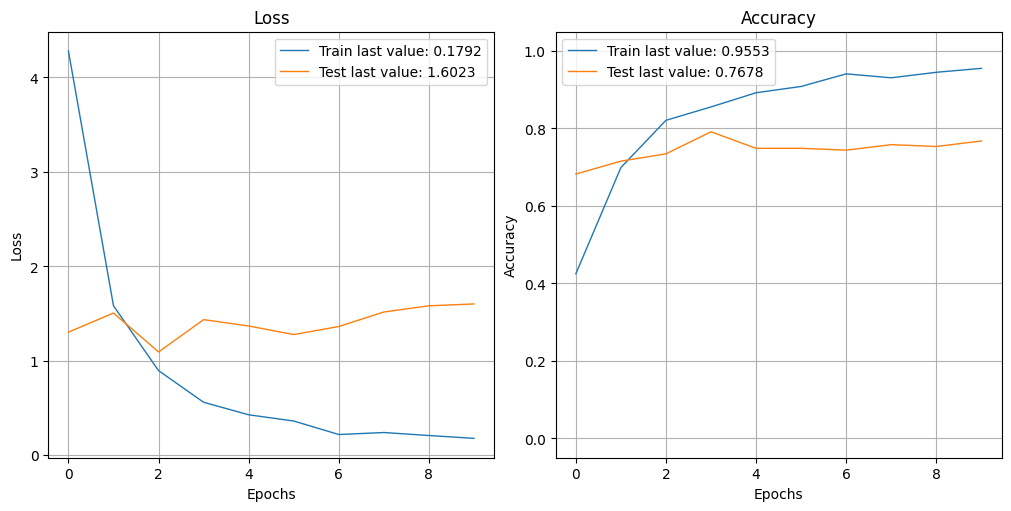

In [61]:
show_history(history)
plt.close()

# Model DIY

In [62]:
from tensorflow import keras

In [63]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(3, 6, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)
    x = layers.Conv2D(6, 16, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)
    x = layers.Conv2D(6*6, 32, strides=2, padding="same")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(32*5*5, activation='relu')(x)
    x = layers.Dense(16*5*5, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(120, activation='relu')(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape[1:3] + (3,), num_classes=nb_cat_little)

In [64]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 3)       327       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 6)         4614      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                         

In [65]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.005, mode='max', patience=6, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/20
16/16 [==============================] - 6s 326ms/step - loss: 1.9419 - accuracy: 0.1443 - val_loss: 1.8980 - val_accuracy: 0.2180
Epoch 2/20
16/16 [==============================] - 5s 326ms/step - loss: 1.7778 - accuracy: 0.2907 - val_loss: 1.8207 - val_accuracy: 0.3602
Epoch 3/20
16/16 [==============================] - 5s 346ms/step - loss: 1.6296 - accuracy: 0.3821 - val_loss: 1.6500 - val_accuracy: 0.4218
Epoch 4/20
16/16 [==============================] - 5s 318ms/step - loss: 1.5158 - accuracy: 0.4472 - val_loss: 1.5342 - val_accuracy: 0.4645
Epoch 5/20
16/16 [==============================] - 5s 311ms/step - loss: 1.3587 - accuracy: 0.5142 - val_loss: 1.4825 - val_accuracy: 0.4313
Epoch 6/20
16/16 [==============================] - 5s 309ms/step - loss: 1.2412 - accuracy: 0.5528 - val_loss: 1.4858 - val_accuracy: 0.4597
Epoch 7/20
16/16 [==============================] - 6s 357ms/step - loss: 1.1591 - accuracy: 0.5630 - val_loss: 1.4375 - val_accuracy: 0.4834
Epoch 

In [66]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 1s 94ms/step

Temps de prédiction (en s):  1.19
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  3

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.5014409221902018

Score de Cohen kappa sur le set de test :
0.4185465358426237

Coefficient de corrélation de Matthews sur le set de test :
0.42285938355535063


# VGG16

In [67]:
from tensorflow.keras.applications.vgg16 import VGG16 as VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

Chargement du modèle en figeant toutes les couches sauf les dernières (celles de classification)

In [68]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [69]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Ajout des dernières couches pour la prédiction addapté à nos targets

In [70]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 70)                1756230   
                                                                 
 dropout_2 (Dropout)         (None, 70)                0         
                                                                 
 dense_8 (Dense)             (None, 28)                1988      
                                                                 
 dense_9 (Dense)             (None, 7)                 203       
                                                                 
Total params: 16,473,109
Trainable params: 1,758,421
N

In [72]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.005, mode='max', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/30
16/16 [==============================] - 151s 10s/step - loss: 1.6799 - accuracy: 0.3598 - val_loss: 1.2299 - val_accuracy: 0.5450
Epoch 2/30
16/16 [==============================] - 154s 10s/step - loss: 0.8832 - accuracy: 0.7114 - val_loss: 1.0243 - val_accuracy: 0.6919
Epoch 3/30
16/16 [==============================] - 152s 10s/step - loss: 0.5542 - accuracy: 0.8110 - val_loss: 0.9305 - val_accuracy: 0.7299
Epoch 4/30
16/16 [==============================] - 160s 10s/step - loss: 0.3353 - accuracy: 0.8821 - val_loss: 0.9652 - val_accuracy: 0.7346
Epoch 5/30
16/16 [==============================] - 152s 10s/step - loss: 0.2473 - accuracy: 0.9370 - val_loss: 0.9444 - val_accuracy: 0.7536
Epoch 6/30
16/16 [==============================] - 152s 10s/step - loss: 0.1822 - accuracy: 0.9512 - val_loss: 0.9741 - val_accuracy: 0.7536
Epoch 7/30
16/16 [==============================] - 152s 10s/step - loss: 0.1474 - accuracy: 0.9634 - val_loss: 1.0695 - val_accuracy: 0.7393
Epoch 

In [73]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 75s 7s/step

Temps de prédiction (en s):  75.18
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  216

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.8097982708933718

Score de Cohen kappa sur le set de test :
0.778079244953924

Coefficient de corrélation de Matthews sur le set de test :
0.7790991637587263


# Xception

In [74]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [75]:
base_model = Xception(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [76]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

Ajout des dernières couches pour la prédiction addapté à nos targets

In [77]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 70)                7024710   
                                                                 
 dropout_3 (Dropout)         (None, 70)                0         
                                                                 
 dense_11 (Dense)            (None, 28)                1988      
                                                                 
 dense_12 (Dense)            (None, 7)                 203       
                                                                 
Total params: 27,888,381
Trainable params: 7,026,901
N

In [79]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.005, mode='max', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/30
16/16 [==============================] - 66s 4s/step - loss: 2.6631 - accuracy: 0.4715 - val_loss: 1.3481 - val_accuracy: 0.6967
Epoch 2/30
16/16 [==============================] - 63s 4s/step - loss: 0.8914 - accuracy: 0.7459 - val_loss: 1.1350 - val_accuracy: 0.7251
Epoch 3/30
16/16 [==============================] - 63s 4s/step - loss: 0.6259 - accuracy: 0.8049 - val_loss: 1.3995 - val_accuracy: 0.7346
Epoch 4/30
16/16 [==============================] - 64s 4s/step - loss: 0.5696 - accuracy: 0.8415 - val_loss: 1.2903 - val_accuracy: 0.7867
Epoch 5/30
16/16 [==============================] - 64s 4s/step - loss: 0.3001 - accuracy: 0.9065 - val_loss: 1.4562 - val_accuracy: 0.7915
Epoch 6/30
16/16 [==============================] - 63s 4s/step - loss: 0.2249 - accuracy: 0.9329 - val_loss: 1.3883 - val_accuracy: 0.7915
Epoch 7/30
16/16 [==============================] - 68s 4s/step - loss: 0.2130 - accuracy: 0.9268 - val_loss: 1.6090 - val_accuracy: 0.8009
Epoch 8/30
16/16 [==

In [80]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 34s 3s/step

Temps de prédiction (en s):  34.44
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  99

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.7694524495677233

Score de Cohen kappa sur le set de test :
0.7310390264697904

Coefficient de corrélation de Matthews sur le set de test :
0.7343332656128615
